# Taller: Aplicación de Machine Learning en PLN
## Integrantes:
- Nicolas Santiago Acosta Parra
- Anderson Giovany Carreño Rincon
- Johan Sebastián Gil Salmanca
- Edison Ferney Gutierrez Buitrago

## Cargar librerías necesarias

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
import re

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print('Librerías cargadas correctamente')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...


Librerías cargadas correctamente


[nltk_data]   Package omw-1.4 is already up-to-date!


## 1) Cargar dataset

In [101]:
import pandas as pd

# Cargar tu dataset
df_deporte = pd.read_csv('news_data.csv')

# Verificar columnas
print(df_deporte.columns)
print("Total de artículos:", len(df_deporte))

# Usar el contenido textual
df = df_deporte[['title', 'content', 'issports']].fillna('')
df['texto'] = df_deporte['title'] + ' ' + df_deporte['content']

print(df['issports'].value_counts())
df.head()


Index(['category', 'filename', 'title', 'issports', 'content'], dtype='object')
Total de artículos: 1121
issports
0    610
1    511
Name: count, dtype: int64


,title,content,issports,texto
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,0,Ad sales boost Time Warner profit Quarterly p...
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,0,Dollar gains on Greenspan speech The dollar h...
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,0,Yukos unit buyer faces loan claim The owners ...
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,0,High fuel prices hit BA's profits British Air...
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,0,Pernod takeover talk lifts Domecq Shares in U...


## 2) Preprocesamiento

En este apartado se realiza la limpieza de los textos: minúsculas, sin símbolos, sin stopwords, tokenizamos y lematizamos.

In [102]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def limpiar_texto(texto):
    texto = str(texto).lower()
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)
    texto = re.sub(r'[^a-z\s]', '', texto)
    tokens = nltk.word_tokenize(texto)
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 1]
    return ' '.join(tokens)

df['texto_limpio'] = df['texto'].apply(limpiar_texto)
df.head()

#Correción inglés
#stop_words = set(stopwords.words('english'))
#stemmer = SnowballStemmer('english')
#
#def limpiar_texto(texto):
#    texto = str(texto).lower()
#    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)  # quitar URLs
#    texto = re.sub(r'[^a-z\s]', '', texto)  # quitar puntuación/números
#    tokens = nltk.word_tokenize(texto)
#    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 1]
#    return ' '.join(tokens)
#
#df['texto_limpio'] = df['texto'].apply(limpiar_texto)
#df.head()

,title,content,issports,texto,texto_limpio
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,0,Ad sales boost Time Warner profit Quarterly p...,ad sale boost time warner profit quarter profi...
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,0,Dollar gains on Greenspan speech The dollar h...,dollar gain greenspan speech dollar hit highes...
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,0,Yukos unit buyer faces loan claim The owners ...,yuko unit buyer face loan claim owner embattl ...
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,0,High fuel prices hit BA's profits British Air...,high fuel price hit bas profit british airway ...
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,0,Pernod takeover talk lifts Domecq Shares in U...,pernod takeov talk lift domecq share uk drink ...


## 3) Representación del texto

Se usa Bag of Words (CountVectorizer) y TF-IDF (TfidfVectorizer) para convertir texto a vectores.

In [103]:
# Vectorizadores
bow = CountVectorizer()
tfidf = TfidfVectorizer()

X_bow = bow.fit_transform(df['texto_limpio'])
X_tfidf = tfidf.fit_transform(df['texto_limpio'])

y = df['issports']

print('Tamaño X_bow:', X_bow.shape)
print('Tamaño X_tfidf:', X_tfidf.shape)

Tamaño X_bow: (1121, 13762)
Tamaño X_tfidf: (1121, 13762)


## 4) División de datos y entrenamiento de modelos

Se divide los datos en entrenamiento y prueba para posteriormente probar los distintos modelos.

Modelos: Naive Bayes, Regresión Logística y Random Forest.

Se usa TF-IDF por defecto para entrenar.

In [104]:
# División
#ros = RandomOverSampler(random_state=42)
#X_resampled, y_resampled = ros.fit_resample(X_tfidf, y)
#
#print("Antes del balanceo:", y.value_counts().to_dict())
#print("Después del balanceo:", pd.Series(y_resampled).value_counts().to_dict())

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42, stratify=y)

# Modelos
models = {
    'Naive Bayes': MultinomialNB(),
    'Regresión Logística': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

resultados = {}

for nombre, modelo in models.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print(f"\n### Resultado: {nombre}")
    print(classification_report(y_test, y_pred))
    resultados[nombre] = (modelo, y_pred)



### Resultado: Naive Bayes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       183
           1       1.00      1.00      1.00       154

    accuracy                           1.00       337
   macro avg       1.00      1.00      1.00       337
weighted avg       1.00      1.00      1.00       337


### Resultado: Regresión Logística
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       183
           1       0.99      1.00      1.00       154

    accuracy                           1.00       337
   macro avg       1.00      1.00      1.00       337
weighted avg       1.00      1.00      1.00       337


### Resultado: Random Forest
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       183
           1       0.99      0.99      0.99       154

    accuracy                           0.99       337
   macro avg       0.99      0.99 

## 5) Matrices de confusión

Se muestra una matriz por cada modelo.

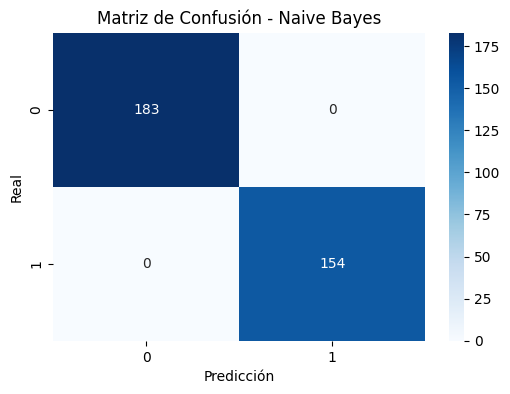

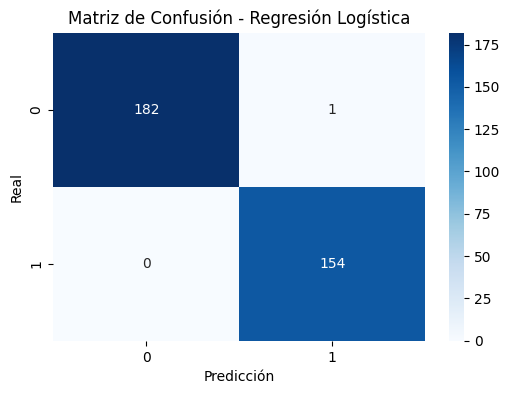

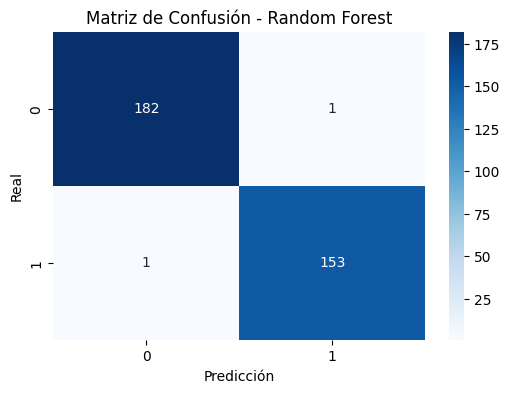

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

for nombre, (modelo, y_pred) in resultados.items():
    cm = confusion_matrix(y_test, y_pred, labels=y.unique())
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=y.unique(), yticklabels=y.unique(), cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()


## 6) WordClouds por categoría

Visualizar términos frecuentes por categoría.

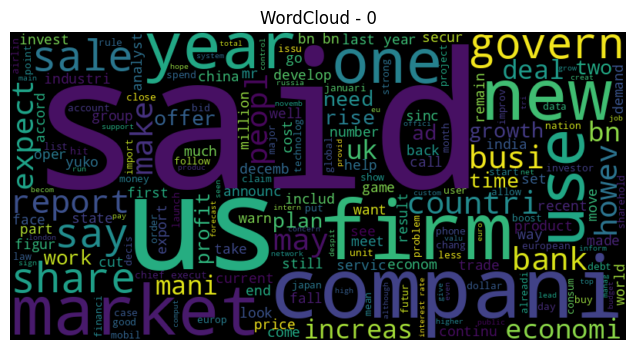

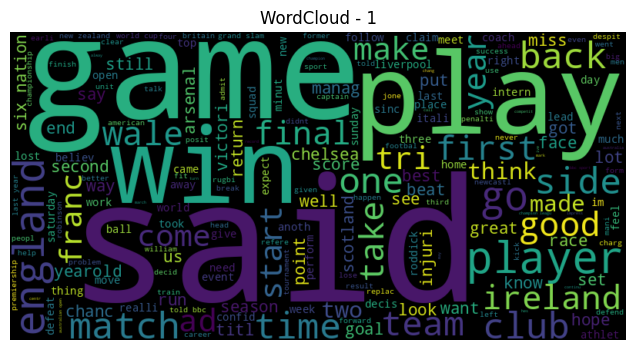

In [106]:
from wordcloud import WordCloud

for cat in df['issports'].unique():
    texto_cat = ' '.join(df[df['issports']==cat]['texto_limpio'])
    if texto_cat.strip() == '':
        continue
    wc = WordCloud(width=800, height=400).generate(texto_cat)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - {cat}')
    plt.show()


## 7) Curva ROC / AUC 

Para problemas multicategoría calculamos AUC por clase usando decision_function o predict_proba cuando esté disponible.

In [107]:
# Intentamos calcular AUC para Regresión Logística (si tiene metodo predict_proba)
from sklearn.preprocessing import label_binarize

modelo_lr = models['Regresión Logística']
if hasattr(modelo_lr, 'predict_proba'):
    y_test_bin = label_binarize(y_test, classes=list(y.unique()))
    y_score = modelo_lr.predict_proba(X_test)
    # Calcular AUC por clase
    try:
        aucs = {}
        for i, clase in enumerate(y.unique()):
            auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
            aucs[clase] = auc
        print('AUC por clase:', aucs)
    except Exception as e:
        print('No se pudo calcular AUC (posible número de clases pequeño):', e)
else:
    print('El modelo no soporta predict_proba')

No se pudo calcular AUC (posible número de clases pequeño): index 1 is out of bounds for axis 1 with size 1


## 8) Guardar resultados y conclusiones

In [108]:
## Ejemplo: guardar predicciones del mejor modelo (por claridad usamos Regresión Logística)
#predicciones = pd.DataFrame({'texto': df.loc[X_test.indices if hasattr(X_test, 'indices') else X_test.shape,'texto'] if False else df.loc[y_test.index,'texto'],
#                             'real': y_test.values,
#                             'pred': resultados['Regresión Logística'][1]})
#
## Mostrar predicciones
#predicciones
#
## Guardar CSV
#predicciones.to_csv('predicciones_pln.csv', index=False)
#print('Predicciones guardadas en el archivo predicciones_pln.csv')

#OPCIÓN 2
#modelo_nombre = 'Regresión Logística'
#y_pred = resultados[modelo_nombre][1]
#
#predicciones = pd.DataFrame({
#    'texto': textos_test,
#    'real': y_test,
#    'pred': y_pred
#})
#
##Guardar en CSV
#predicciones.to_csv('predicciones_pln.csv', index=False)
#print('Predicciones guardadas en el archivo predicciones_pln.csv')

## 9) Conclusiones

- Resumit los resultados de los modelos (precisión, recall, F1).
- Mencionar limitaciones (poca data de ejemplo, desequilibrio posible).
- Sugerencias de mejora: más datos, embeddings (Word2Vec, FastText), modelos preentrenados (BERT), ajuste de hiperparámetros.

In [114]:
#Forma de predecir texto ingresado:
def predecir_texto(texto):
    texto_limpio = limpiar_texto(texto)
    vector = tfidf.transform([texto_limpio])
    pred = modelo.predict(vector)[0]
    return "Es sobre deportes" if pred == 1 else "No es sobre deportes"

print("-"*35)
print("Textos relacionados con deporte")
print("-"*35)
print(predecir_texto("Cristiano Ronaldo scored a stunning goal in the final minutes of the game."))
print(predecir_texto("The Lakers secured another victory with LeBron James leading the scoreboard."))
print(predecir_texto("Serena Williams announced her retirement after an incredible career in tennis."))
print(predecir_texto("The World Cup final attracted millions of viewers around the globe."))
print(predecir_texto("Liverpool’s defense was solid throughout the entire match against Chelsea."))
print(predecir_texto("The Olympic Games will feature new sports such as skateboarding and surfing."))
print(predecir_texto("Manchester City lifted the Premier League trophy after a 3-0 win."))
print(predecir_texto("The coach praised his team’s discipline and teamwork after the victory."))
print(predecir_texto("A new record was set in the 100-meter sprint by an American athlete."))
print(predecir_texto("Fans celebrated wildly as their team qualified for the Champions League final."))

print()
print("-"*35)
print("Textos No relacionados con deporte")
print("-"*35)
print(predecir_texto("The government announced a new plan to improve public transportation."))
print(predecir_texto("A massive wildfire spread through the northern region causing evacuations."))
print(predecir_texto("Apple unveiled its latest iPhone model with advanced camera technology."))
print(predecir_texto("The stock market saw a significant drop due to global economic concerns."))
print(predecir_texto("Scientists developed a new vaccine that shows promising results."))
print(predecir_texto("Tourism in Europe is expected to rise during the summer season."))
print(predecir_texto("The new education policy aims to reduce inequality in rural areas."))
print(predecir_texto("A famous actor announced his return to Hollywood after a long break."))
print(predecir_texto("The museum opened a new exhibition about ancient Egyptian culture."))
print(predecir_texto("Heavy rains caused flooding in several cities across the country."))



-----------------------------------
Textos relacionados con deporte
-----------------------------------
Es sobre deportes
Es sobre deportes
No es sobre deportes
Es sobre deportes
Es sobre deportes
Es sobre deportes
Es sobre deportes
Es sobre deportes
Es sobre deportes
Es sobre deportes

-----------------------------------
Textos No relacionados con deporte
-----------------------------------
No es sobre deportes
No es sobre deportes
No es sobre deportes
No es sobre deportes
No es sobre deportes
No es sobre deportes
No es sobre deportes
No es sobre deportes
No es sobre deportes
No es sobre deportes
